In [ ]:
import zipfile
import os

zip_path = "/content/car_images.zip"
extract_path = "/content/car_images"

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_path)

print("Extracted to:", extract_path)
print("Inner folders:", os.listdir(extract_path))


Extracted to: /content/car_images
Inner folders: ['car_images']


In [ ]:
DATA_ROOT = "/content/car_images/car_images"

print("Classes found:", os.listdir(DATA_ROOT))


Classes found: ['front', 'rearleft', 'frontright', 'rear', 'rearright', 'random', 'frontleft']


In [ ]:
from torchvision import datasets, transforms

DATA_ROOT = "/content/car_images/car_images"

dataset = datasets.ImageFolder(DATA_ROOT)

print("Classes:", dataset.classes)
print("Class to index mapping:", dataset.class_to_idx)


Classes: ['front', 'frontleft', 'frontright', 'random', 'rear', 'rearleft', 'rearright']
Class to index mapping: {'front': 0, 'frontleft': 1, 'frontright': 2, 'random': 3, 'rear': 4, 'rearleft': 5, 'rearright': 6}


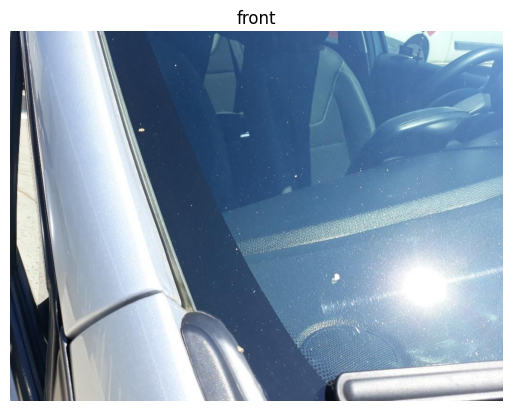

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import random

cls = random.choice(dataset.classes)
img_path, label = random.choice(
    [s for s in dataset.samples if dataset.classes[s[1]] == cls]
)

img = Image.open(img_path)
plt.imshow(img)
plt.title(cls)
plt.axis("off")
plt.show()


In [ ]:
from torchvision import transforms

IMG_SIZE = 224

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [ ]:
from torchvision import datasets

DATA_ROOT = "/content/car_images/car_images"

dataset = datasets.ImageFolder(
    DATA_ROOT,
    transform=train_tfms
)

print("Dataset ready. Sample type:", type(dataset[0][0]))


Dataset ready. Sample type: <class 'torch.Tensor'>


In [ ]:
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


Using device: cuda


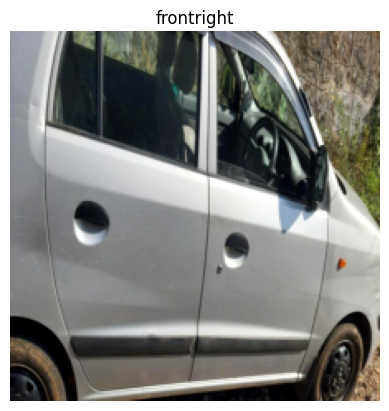

In [ ]:
import torch
import matplotlib.pyplot as plt
import random

img, label = dataset[random.randint(0, len(dataset)-1)]

# unnormalize for display
img_disp = img.clone()
img_disp = img_disp * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
img_disp = img_disp + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
img_disp = img_disp.permute(1,2,0)

plt.imshow(img_disp)
plt.title(dataset.classes[label])
plt.axis("off")
plt.show()


In [ ]:
from torch.utils.data import DataLoader, random_split

BATCH_SIZE = 32

val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

# IMPORTANT: validation should NOT have augmentation
val_ds.dataset.transform = val_tfms

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

print("Train samples:", len(train_ds))
print("Val samples:", len(val_ds))


Train samples: 3180
Val samples: 794


In [ ]:
class_names = dataset.classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Num classes:", num_classes)

Classes: ['front', 'frontleft', 'frontright', 'random', 'rear', 'rearleft', 'rearright']
Num classes: 7


In [ ]:
from torchvision import models
import torch.nn as nn

model = models.mobilenet_v2(weights="IMAGENET1K_V1")

# 🔒 Freeze all layers first
for p in model.features.parameters():
    p.requires_grad = False

# 🔓 Unfreeze last 4 inverted residual blocks
for layer in model.features[-4:]:
    for p in layer.parameters():
        p.requires_grad = True

# Replace classifier
model.classifier[1] = nn.Linear(model.last_channel, num_classes)

model = model.to(DEVICE)


In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-5   # VERY IMPORTANT for fine-tuning
)


In [ ]:
from torch.utils.data import random_split, DataLoader

val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
val_ds.dataset.transform = val_tfms

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)


In [ ]:
from tqdm import tqdm

EPOCHS = 40
PATIENCE = 5

train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_val_loss = float("inf")
patience_ctr = 0


In [ ]:
for epoch in range(EPOCHS):

    # ---------------- TRAIN ----------------
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [TRAIN]")

    for imgs, labels in train_bar:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        train_bar.set_postfix(
            loss=loss.item(),
            acc=correct / total
        )

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # ---------------- VALIDATION ----------------
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [VAL]")

    with torch.no_grad():
        for imgs, labels in val_bar:
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            val_bar.set_postfix(
                loss=loss.item(),
                acc=correct / total
            )

    val_loss = running_loss / len(val_loader)
    val_acc = correct / total

    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(
        f"\nEpoch {epoch+1}: "
        f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f} | "
        f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}"
    )

    # ---------------- EARLY STOPPING ----------------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_ctr = 0

        torch.save({
            "model_state": model.state_dict(),
            "class_names": class_names
        }, "/content/orientation_mobilenet_v2_best.pt")

    else:
        patience_ctr += 1
        if patience_ctr >= PATIENCE:
            print("⏹️ Early stopping triggered")
            break


Epoch 1/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.34it/s, acc=0.39, loss=1.65]



Epoch 1: Train Loss=1.8145, Train Acc=0.2730 | Val Loss=1.6415, Val Acc=0.3904


Epoch 2/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.31it/s, acc=0.48, loss=1.39]



Epoch 2: Train Loss=1.5603, Train Acc=0.4116 | Val Loss=1.4337, Val Acc=0.4798


Epoch 3/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.30it/s, acc=0.552, loss=1.19]



Epoch 3: Train Loss=1.3664, Train Acc=0.5129 | Val Loss=1.2768, Val Acc=0.5516


Epoch 4/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.32it/s, acc=0.589, loss=1.04]



Epoch 4: Train Loss=1.2248, Train Acc=0.5676 | Val Loss=1.1601, Val Acc=0.5894


Epoch 5/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.33it/s, acc=0.623, loss=0.933]



Epoch 5: Train Loss=1.1122, Train Acc=0.6063 | Val Loss=1.0780, Val Acc=0.6234


Epoch 6/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.35it/s, acc=0.654, loss=0.844]



Epoch 6: Train Loss=1.0181, Train Acc=0.6547 | Val Loss=1.0134, Val Acc=0.6537


Epoch 7/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.36it/s, acc=0.678, loss=0.765]



Epoch 7: Train Loss=0.9533, Train Acc=0.6899 | Val Loss=0.9452, Val Acc=0.6776


Epoch 8/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.34it/s, acc=0.707, loss=0.699]



Epoch 8: Train Loss=0.8821, Train Acc=0.7119 | Val Loss=0.8902, Val Acc=0.7065


Epoch 9/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.32it/s, acc=0.733, loss=0.65]



Epoch 9: Train Loss=0.8039, Train Acc=0.7547 | Val Loss=0.8441, Val Acc=0.7330


Epoch 10/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.35it/s, acc=0.752, loss=0.57]



Epoch 10: Train Loss=0.7393, Train Acc=0.7783 | Val Loss=0.7911, Val Acc=0.7519


Epoch 11/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.31it/s, acc=0.762, loss=0.518]



Epoch 11: Train Loss=0.6825, Train Acc=0.8019 | Val Loss=0.7494, Val Acc=0.7620


Epoch 12/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.33it/s, acc=0.776, loss=0.475]



Epoch 12: Train Loss=0.6275, Train Acc=0.8211 | Val Loss=0.7118, Val Acc=0.7758


Epoch 13/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.30it/s, acc=0.783, loss=0.438]



Epoch 13: Train Loss=0.5857, Train Acc=0.8321 | Val Loss=0.6753, Val Acc=0.7834


Epoch 14/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.32it/s, acc=0.8, loss=0.412]



Epoch 14: Train Loss=0.5410, Train Acc=0.8491 | Val Loss=0.6512, Val Acc=0.7997


Epoch 15/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.31it/s, acc=0.804, loss=0.412]



Epoch 15: Train Loss=0.5052, Train Acc=0.8582 | Val Loss=0.6344, Val Acc=0.8035


Epoch 16/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.35it/s, acc=0.798, loss=0.37]



Epoch 16: Train Loss=0.4766, Train Acc=0.8607 | Val Loss=0.6178, Val Acc=0.7985


Epoch 17/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.35it/s, acc=0.812, loss=0.363]



Epoch 17: Train Loss=0.4452, Train Acc=0.8723 | Val Loss=0.6012, Val Acc=0.8123


Epoch 18/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.36it/s, acc=0.807, loss=0.345]



Epoch 18: Train Loss=0.4053, Train Acc=0.8852 | Val Loss=0.5936, Val Acc=0.8073


Epoch 19/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.36it/s, acc=0.817, loss=0.367]



Epoch 19: Train Loss=0.3880, Train Acc=0.8903 | Val Loss=0.5792, Val Acc=0.8174


Epoch 20/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.33it/s, acc=0.825, loss=0.325]



Epoch 20: Train Loss=0.3558, Train Acc=0.9013 | Val Loss=0.5732, Val Acc=0.8249


Epoch 21/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.38it/s, acc=0.82, loss=0.322]



Epoch 21: Train Loss=0.3428, Train Acc=0.9000 | Val Loss=0.5694, Val Acc=0.8199


Epoch 22/40 [VAL]: 100%|██████████| 25/25 [00:11<00:00,  2.27it/s, acc=0.826, loss=0.327]



Epoch 22: Train Loss=0.3236, Train Acc=0.9091 | Val Loss=0.5623, Val Acc=0.8262


Epoch 23/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.29it/s, acc=0.824, loss=0.331]



Epoch 23: Train Loss=0.2989, Train Acc=0.9208 | Val Loss=0.5594, Val Acc=0.8237


Epoch 24/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.29it/s, acc=0.829, loss=0.321]



Epoch 24: Train Loss=0.2761, Train Acc=0.9239 | Val Loss=0.5553, Val Acc=0.8287


Epoch 25/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.34it/s, acc=0.827, loss=0.311]



Epoch 25: Train Loss=0.2572, Train Acc=0.9340 | Val Loss=0.5555, Val Acc=0.8275


Epoch 26/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.33it/s, acc=0.825, loss=0.341]



Epoch 26: Train Loss=0.2478, Train Acc=0.9371 | Val Loss=0.5563, Val Acc=0.8249


Epoch 27/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.35it/s, acc=0.824, loss=0.322]



Epoch 27: Train Loss=0.2345, Train Acc=0.9409 | Val Loss=0.5546, Val Acc=0.8237


Epoch 28/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.37it/s, acc=0.832, loss=0.334]



Epoch 28: Train Loss=0.2092, Train Acc=0.9481 | Val Loss=0.5517, Val Acc=0.8325


Epoch 29/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.34it/s, acc=0.829, loss=0.321]



Epoch 29: Train Loss=0.1905, Train Acc=0.9594 | Val Loss=0.5500, Val Acc=0.8287


Epoch 30/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.41it/s, acc=0.831, loss=0.324]



Epoch 30: Train Loss=0.1839, Train Acc=0.9610 | Val Loss=0.5530, Val Acc=0.8312


Epoch 31/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.36it/s, acc=0.827, loss=0.355]



Epoch 31: Train Loss=0.1634, Train Acc=0.9623 | Val Loss=0.5574, Val Acc=0.8275


Epoch 32/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.37it/s, acc=0.822, loss=0.356]



Epoch 32: Train Loss=0.1502, Train Acc=0.9704 | Val Loss=0.5587, Val Acc=0.8224


Epoch 33/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.35it/s, acc=0.826, loss=0.404]



Epoch 33: Train Loss=0.1417, Train Acc=0.9720 | Val Loss=0.5646, Val Acc=0.8262


Epoch 34/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.35it/s, acc=0.83, loss=0.427]


Epoch 34: Train Loss=0.1339, Train Acc=0.9758 | Val Loss=0.5800, Val Acc=0.8300
⏹️ Early stopping triggered


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)
        preds = outputs.argmax(1).cpu().numpy()

        y_true.extend(labels.numpy())
        y_pred.extend(preds)

print(classification_report(y_true, y_pred, target_names=dataset.classes))
print(confusion_matrix(y_true, y_pred))


              precision    recall  f1-score   support

       front       0.72      0.78      0.75       120
   frontleft       0.90      0.84      0.87       170
  frontright       0.86      0.85      0.86       137
      random       0.71      0.77      0.74       106
        rear       0.83      0.83      0.83        87
    rearleft       0.91      0.93      0.92        85
   rearright       0.92      0.81      0.86        89

    accuracy                           0.83       794
   macro avg       0.83      0.83      0.83       794
weighted avg       0.84      0.83      0.83       794

[[ 94  11   8   7   0   0   0]
 [ 16 143   6   4   0   1   0]
 [ 11   0 117   8   1   0   0]
 [  7   3   2  82   4   4   4]
 [  3   0   1  10  72   0   1]
 [  0   0   1   1   3  79   1]
 [  0   2   1   4   7   3  72]]


In [ ]:
torch.save({
    "model_state": model.state_dict(),
    "class_names": dataset.classes
}, "/content/orientation_mobilenet_v2.pt")

print("Model saved ✅")


Model saved ✅


In [ ]:
from PIL import Image
import torch

def predict_image(img_path):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    img = val_tfms(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        probs = torch.softmax(model(img), dim=1)[0]

    top = torch.argsort(probs, descending=True)[:3]
    for idx in top:
        print(dataset.classes[idx], round(probs[idx].item(), 4))


In [ ]:
ckpt = torch.load("/content/orientation_mobilenet_v2.pt", map_location=DEVICE)
model.load_state_dict(ckpt["model_state"])

predict_image("/content/car_images/car_images/rearright/IMG_20200219_170602_1_1586530525984.jpeg")


rearright 0.9984
rearleft 0.0009
frontleft 0.0004


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 17.4 MB/s eta 0:00:00


In [ ]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm


In [ ]:
def build_model(num_classes, unfreeze_blocks, dropout):
    model = models.mobilenet_v2(weights="IMAGENET1K_V1")

    # Freeze all
    for p in model.features.parameters():
        p.requires_grad = False

    # Unfreeze last N blocks
    if unfreeze_blocks > 0:
        for layer in model.features[-unfreeze_blocks:]:
            for p in layer.parameters():
                p.requires_grad = True

    # Replace classifier with dropout
    model.classifier = nn.Sequential(
        nn.Dropout(dropout),
        nn.Linear(model.last_channel, num_classes)
    )

    return model


In [ ]:
def objective(trial):

    lr = trial.suggest_float("lr", 1e-5, 5e-4, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    unfreeze_blocks = trial.suggest_int("unfreeze_blocks", 2, 6)
    batch_size = trial.suggest_categorical("batch_size", [16, 32])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    model = build_model(num_classes, unfreeze_blocks, dropout).to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr,
        weight_decay=weight_decay
    )

    EPOCHS = 5
    best_val_acc = 0.0

    for epoch in range(5):

        # -------- TRAIN --------
        model.train()
        for imgs, labels in train_loader:
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # -------- VALIDATION --------
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(DEVICE)
                labels = labels.to(DEVICE)

                outputs = model(imgs)
                preds = outputs.argmax(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        best_val_acc = max(best_val_acc, val_acc)

        trial.report(val_acc, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return best_val_acc


In [ ]:
study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=2)
)

study.optimize(objective, n_trials=20)


[I 2025-12-27 04:02:24,488] A new study created in memory with name: no-name-baab6955-0d20-411c-bd3e-2855ade457d3
[I 2025-12-27 04:06:41,992] Trial 0 finished with value: 0.7770780856423174 and parameters: {'lr': 0.00016575801886083166, 'weight_decay': 0.0003792413299361425, 'dropout': 0.18049210202942942, 'unfreeze_blocks': 2, 'batch_size': 32}. Best is trial 0 with value: 0.7770780856423174.
[I 2025-12-27 04:11:02,195] Trial 1 finished with value: 0.8337531486146096 and parameters: {'lr': 4.1317408113144385e-05, 'weight_decay': 0.00046322040010851313, 'dropout': 0.3069212976837837, 'unfreeze_blocks': 4, 'batch_size': 16}. Best is trial 1 with value: 0.8337531486146096.
[I 2025-12-27 04:15:12,383] Trial 2 finished with value: 0.8387909319899244 and parameters: {'lr': 0.00017653974475289943, 'weight_decay': 0.0003070633318995187, 'dropout': 0.46822943890795854, 'unfreeze_blocks': 5, 'batch_size': 32}. Best is trial 2 with value: 0.8387909319899244.
[I 2025-12-27 04:19:32,854] Trial 3 f

In [ ]:
print("Best trial:")
print(study.best_trial.value)

print("Best params:")
for k, v in study.best_trial.params.items():
    print(f"{k}: {v}")


Best trial:
0.8551637279596978
Best params:
lr: 4.8638823668775984e-05
weight_decay: 6.9212019791498516e-06
dropout: 0.4313509899731295
unfreeze_blocks: 6
batch_size: 16


In [ ]:
LR = 4.8638823668775984e-05
WEIGHT_DECAY = 6.9212019791498516e-06
DROPOUT = 0.4313509899731295
UNFREEZE_BLOCKS = 6
BATCH_SIZE = 16
EPOCHS = 40
PATIENCE = 5
SAVE_PATH = "/content/orientation_mobilenet_v2_final.pt"


In [ ]:
from torchvision import models
import torch.nn as nn
import torch

def build_final_model(num_classes):
    model = models.mobilenet_v2(weights="IMAGENET1K_V1")

    # Freeze all
    for p in model.features.parameters():
        p.requires_grad = False

    # Unfreeze last N blocks
    for layer in model.features[-UNFREEZE_BLOCKS:]:
        for p in layer.parameters():
            p.requires_grad = True

    # Classifier
    model.classifier = nn.Sequential(
        nn.Dropout(DROPOUT),
        nn.Linear(model.last_channel, num_classes)
    )

    return model.to(DEVICE)


In [ ]:
model = build_final_model(num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 196MB/s]


In [ ]:
from tqdm import tqdm

best_val_loss = float("inf")
patience_ctr = 0

for epoch in range(EPOCHS):

    # -------- TRAIN --------
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [TRAIN]"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_loss /= len(train_loader)
    train_acc = correct / total

    # -------- VALIDATION --------
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [VAL]"):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total

    print(f"\nEpoch {epoch+1}: "
          f"Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | "
          f"Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")

    # -------- EARLY STOP --------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_ctr = 0

        torch.save({
            "model_state": model.state_dict(),
            "class_names": class_names
        }, SAVE_PATH)
    else:
        patience_ctr += 1
        if patience_ctr >= PATIENCE:
            print("Early stopping")
            break


Epoch 1/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.31it/s]



Epoch 1: Train Loss=1.5167, Acc=0.4239 | Val Loss=1.0822, Acc=0.6196


Epoch 2/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.33it/s]



Epoch 2: Train Loss=0.9825, Acc=0.6591 | Val Loss=0.7736, Acc=0.7645


Epoch 3/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.45it/s]



Epoch 3: Train Loss=0.6533, Acc=0.7969 | Val Loss=0.5728, Acc=0.8224


Epoch 4/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.36it/s]



Epoch 4: Train Loss=0.4620, Acc=0.8619 | Val Loss=0.4921, Acc=0.8401


Epoch 5/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.32it/s]



Epoch 5: Train Loss=0.3454, Acc=0.8937 | Val Loss=0.4609, Acc=0.8514


Epoch 6/40 [VAL]: 100%|██████████| 25/25 [00:11<00:00,  2.27it/s]



Epoch 6: Train Loss=0.2517, Acc=0.9292 | Val Loss=0.4410, Acc=0.8539


Epoch 7/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.46it/s]



Epoch 7: Train Loss=0.1805, Acc=0.9541 | Val Loss=0.4439, Acc=0.8401


Epoch 8/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.28it/s]



Epoch 8: Train Loss=0.1239, Acc=0.9708 | Val Loss=0.4463, Acc=0.8476


Epoch 9/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.28it/s]



Epoch 9: Train Loss=0.0843, Acc=0.9877 | Val Loss=0.4584, Acc=0.8401


Epoch 10/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.30it/s]



Epoch 10: Train Loss=0.0664, Acc=0.9915 | Val Loss=0.4523, Acc=0.8564


Epoch 11/40 [VAL]: 100%|██████████| 25/25 [00:10<00:00,  2.34it/s]


Epoch 11: Train Loss=0.0494, Acc=0.9953 | Val Loss=0.4502, Acc=0.8564
Early stopping


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)
        preds = outputs.argmax(1).cpu().numpy()

        y_true.extend(labels.numpy())
        y_pred.extend(preds)

# ---- Confusion Matrix ----
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# ---- Classification Report ----
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Confusion Matrix:
 [[ 91   6   5   3   4   0   0]
 [  4 152   2   6   0   0   1]
 [ 16   6 123   5   0   0   1]
 [  4   7   7  80   4   1   4]
 [  1   0   0   5  72   3   4]
 [  0   1   2   2   1  80   1]
 [  0   1   0   1   6   0  82]]

Classification Report:
              precision    recall  f1-score   support

       front       0.78      0.83      0.81       109
   frontleft       0.88      0.92      0.90       165
  frontright       0.88      0.81      0.85       151
      random       0.78      0.75      0.77       107
        rear       0.83      0.85      0.84        85
    rearleft       0.95      0.92      0.94        87
   rearright       0.88      0.91      0.90        90

    accuracy                           0.86       794
   macro avg       0.86      0.86      0.86       794
weighted avg       0.86      0.86      0.86       794



In [ ]:
torch.save({
    "model_state": model.state_dict(),
    "class_names": class_names
}, "/content/orientation_mobilenet_v2_final.pt")

print("Final model saved ✅")


Final model saved ✅


In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import torch.nn as nn

# -------- CONFIG --------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "/content/orientation_mobilenet_v2_final.pt"
IMG_SIZE = 224

# -------- TRANSFORMS (MUST MATCH VAL) --------
val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [ ]:
# -------- LOAD MODEL --------
ckpt = torch.load(MODEL_PATH, map_location=DEVICE)
class_names = ckpt["class_names"]
num_classes = len(class_names)

model = models.mobilenet_v2(weights=None)
model.classifier[1] = nn.Linear(model.last_channel, num_classes)
model.load_state_dict(ckpt["model_state"])

model = model.to(DEVICE)
model.eval()


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
# -------- SINGLE IMAGE PREDICTION --------
def predict_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img = val_tfms(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        outputs = model(img)
        pred_idx = outputs.argmax(1).item()

    return class_names[pred_idx]


In [ ]:
# -------- TEST --------
predict_image("/content/rear-right-view-green-colored-modern-hatchbag-car-white-background-411032281.webp")


'rearright'

In [ ]:
!pip install onnx onnxruntime tf2onnx tensorflow

INFO: pip is looking at multiple versions of tf2onnx to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of tf2onnx to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warni

In [ ]:
!pip install onnxscript

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.4/693.4 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 9.4 MB/s eta 0:00:00


In [ ]:
import torch
from torchvision import models
import torch.nn as nn

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "/content/orientation_mobilenet_v2_final.pt"
ONNX_PATH = "/content/orientation_mobilenet_v2.onnx"

ckpt = torch.load(MODEL_PATH, map_location=DEVICE)
class_names = ckpt["class_names"]
num_classes = len(class_names)

model = models.mobilenet_v2(weights=None)
model.classifier[1] = nn.Linear(model.last_channel, num_classes)
model.load_state_dict(ckpt["model_state"])
model.eval().to(DEVICE)

dummy_input = torch.randn(1, 3, 224, 224).to(DEVICE)

torch.onnx.export(
    model,
    dummy_input,
    ONNX_PATH,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch"}, "output": {0: "batch"}},
    opset_version=11
)

print("ONNX export done ✅")


/tmp/ipython-input-3100657075.py:20: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W1228 04:12:53.858000 610 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 11 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `MobileNetV2([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `MobileNetV2([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/adapters/axes_input_to_attribute.h:65: adapt: Asserti

[torch.onnx] Translate the graph into ONNX... ✅
Applied 104 of general pattern rewrite rules.
ONNX export done ✅


In [ ]:
!pip install onnx2tf tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.9/151.9 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 70.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
onnx-ir 0.1.13 requires onnx>=1.16, which is not installed.
onnxscript 0.5.7 requires onnx>=1.16, which is not installed.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.1.3 which is incompatible.


In [ ]:
!pip install onnx

  Using cached onnx-1.20.0-cp312-abi3-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (8.4 kB)
Using cached onnx-1.20.0-cp312-abi3-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (18.1 MB)


In [ ]:
!pip install onnx-graphsurgeon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 5.5 MB/s eta 0:00:00


In [ ]:
!pip uninstall -y onnx onnx-graphsurgeon
!pip install onnx==1.15.0 onnx-graphsurgeon==0.5.2

  Using cached onnx-1.15.0.tar.gz (12.3 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached onnx_graphsurgeon-0.5.2-py2.py3-none-any.whl.metadata (8.1 kB)
Using cached onnx_graphsurgeon-0.5.2-py2.py3-none-any.whl (56 kB)
  Created wheel for onnx: filename=onnx-1.15.0-cp312-cp312-linux_x86_64.whl size=15945614 sha256=c61d827dfd4b2f122d78843b4627ff0d6cf24267060eacca13f43a3cafe9f4a3
  Stored in directory: /root/.cache/pip/wheels/4a/fd/ab/6b6613d123c35464ba4d85827c819faa9888bf51efee86dfa8
Successfully built onnx
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
onnx-ir 0.1.13 requires onnx>=1.16, but you have onnx 1.15.0 which is incompatible.
onnxscript 0.5.7 requires onnx>=1.16, but you have onnx 1.15.0 which is incompatible.


In [ ]:
!pip install ai-edge-litert

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 47.8 MB/s eta 0:00:00


In [ ]:
!pip install sng4onnx

In [ ]:
!onnx2tf \
  -i /content/orientation_mobilenet_v2.onnx \
  -o /content/tf_model


E0000 00:00:1766898059.335009   27863 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766898059.345276   27863 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766898059.370995   27863 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766898059.371037   27863 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766898059.371045   27863 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766898059.371053   27863 computation_placer.cc:177] computation placer already registered. Please check linka

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model("/content/tf_model")

# Force ONLY stable builtin ops (no Select TF Ops)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS
]

# Disable all optimizations (most compatible)
converter.optimizations = []

# IMPORTANT: do NOT use experimental_new_converter in TF 2.16+
tflite_model = converter.convert()

with open("/content/orientation_mobilenet_v2_compat.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Compatible TFLite model saved")


✅ Compatible TFLite model saved


In [ ]:
import torch

In [ ]:
ckpt = torch.load("orientation_mobilenet_v2_final.pt")
print(ckpt["class_names"])

['front', 'frontleft', 'frontright', 'random', 'rear', 'rearleft', 'rearright']
